# Steps:

1. Import libraries
2. First look at the data - load data and check for nulls
3. Data cleanup
4. Scale data
5. EDA <br />
    5.1. Box plots <br />
    5.2. Handle Outliers <br />
    5.3. Pair plot analysis <br />
    5.4. Heat map analysis <br />
6. Clustering <br />
    6.1. K-means clustering <br />
    6.2. Agglomerative clustering <br />
    6.3. Cophenetic coefficient and dendograms <br />
7. Conclusion<br />
    7.1. Recommendations for marketting team <br />
    7.2. Recommendations for ops team <br />
    

# Import libraries

In [1]:
# Linear algebra libs
import numpy as np
import pandas as pd

# Visualization libs
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

# First look at data

In [3]:
file_name = "Credit Card Customer Data.xlsx"
cc_data = pd.read_excel(file_name)
cc_data.shape

(660, 7)

In [4]:
cc_data.head()

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1,87073,100000,2,1,1,0
1,2,38414,50000,3,0,10,9
2,3,17341,50000,7,1,3,4
3,4,40496,30000,5,1,1,4
4,5,47437,100000,6,0,12,3


In [5]:
cc_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660 entries, 0 to 659
Data columns (total 7 columns):
Sl_No                  660 non-null int64
Customer Key           660 non-null int64
Avg_Credit_Limit       660 non-null int64
Total_Credit_Cards     660 non-null int64
Total_visits_bank      660 non-null int64
Total_visits_online    660 non-null int64
Total_calls_made       660 non-null int64
dtypes: int64(7)
memory usage: 36.2 KB


In [6]:
cc_data.describe().T

,count,mean,std,min,25%,50%,75%,max
Sl_No,660.0,330.500000,190.669872,1.0,165.75,330.5,495.25,660.0
Customer Key,660.0,55141.443939,25627.772200,11265.0,33825.25,53874.5,77202.50,99843.0
Avg_Credit_Limit,660.0,34574.242424,37625.487804,3000.0,10000.00,18000.0,48000.00,200000.0
Total_Credit_Cards,660.0,4.706061,2.167835,1.0,3.00,5.0,6.00,10.0
Total_visits_bank,660.0,2.403030,1.631813,0.0,1.00,2.0,4.00,5.0
Total_visits_online,660.0,2.606061,2.935724,0.0,1.00,2.0,4.00,15.0
Total_calls_made,660.0,3.583333,2.865317,0.0,1.00,3.0,5.00,10.0


#### Observations

1. No null data
2. Avg credit limit data is at higher scale than the rest of data so, we need to perform scaling otherwise this column will dominate the results
3. Columns Sl_No and 'Customer Key' need to be dropped since these columns are identifiers and do not bring more infomation about clustering

# Data cleanup

In [7]:
# Check for duplicates
indexes_to_drop = cc_data[cc_data['Customer Key'].duplicated(keep='first')].index

In [8]:
# Drop the indexes found in previous steps
cc_data.drop(index=indexes_to_drop, inplace=True)

In [9]:
# Drop the Sl_No columns since it brings no information in clustering
cc_data.drop('Sl_No', axis=1, inplace=True)

In [10]:
# Drop the 'Customer Key' since it brings no information in clustering
cc_data.drop('Customer Key', axis=1, inplace=True)

# Scale data

In [11]:
# Scale the data otherwise Avg_Credit_Limit will dominate the results

from scipy.stats import zscore

cc_data_scaled = cc_data.apply(zscore)

# EDA

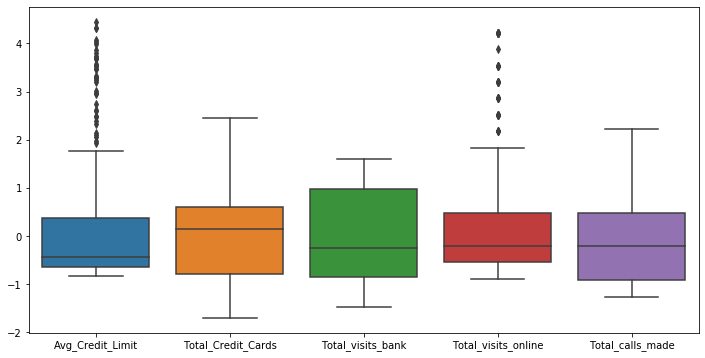

In [12]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=cc_data_scaled)

#### Observations

1. It appears that there are outliers in Avg_Credit_Limit in Total_visits_online
2. But treating outliers at this point will affect the result of k-means clustering. K-means clustering will not show a clear elbow after outliers treatment

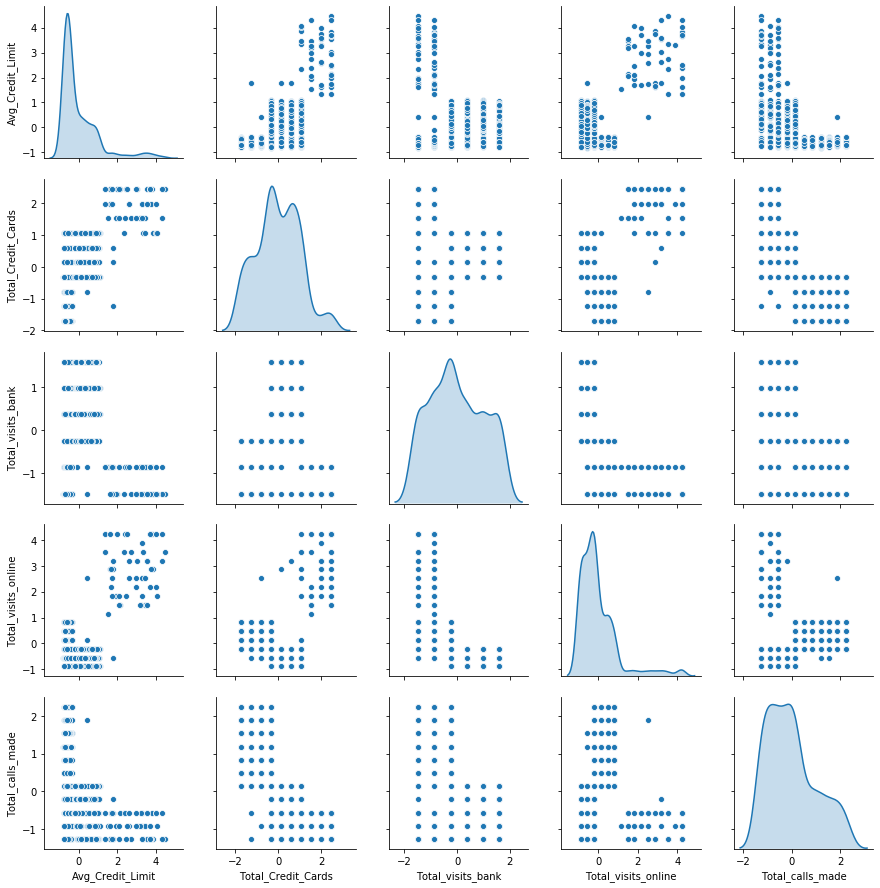

In [13]:
sns.pairplot(cc_data_scaled, diag_kind='kde')

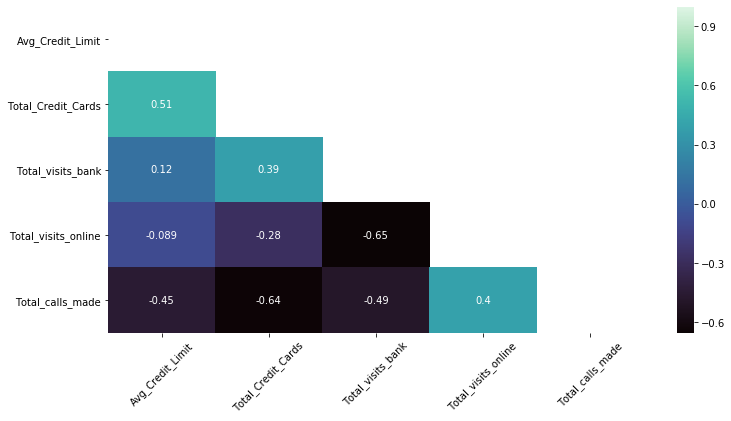

In [14]:
plt.subplots(figsize=(12, 6))
corr = cc_data_scaled.corr('spearman')

mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

ax = sns.heatmap(data=corr, cmap='mako', annot=True, mask=mask)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45);

#### Observations

<b>Dignoal analysis</b>
1. Long right tail can be seen for Avg_Credit_Limit, Total_visits_online
2. Multiple gausians are seen for Total_Credit_Cards
3. Total bank visits are mirrored around center


<b>Off diagonal analysis</b>
1. Avg_Credit_Limit and Total_Credit_Cards appear to form two clusters (This is expected)
2. Avg_Credit_Limit and Total_visits_bank appear to form 2-3 clusters
3. Avg_Credit_Limit and Total_visits_online appear to form two clusters
4. Slight negative correlation is seen between Avg_Credit_Limit and Total_calls_made
5. Total_Credit_Cards and Total_visits_banks appear to form 2-3 clusters
6. Total_Credit_Cards and Total_visits_online form 2 clusters
7. Total_Credit_Cards and Total_Calls_made for 2-3 clusters
8. Total_visits_bank and Total_visits_online form at least two clusters
9. Total_visits_bank and Total_calls_made form at least two clusters
10. Total_visits_online and Total_calls_made form 3 clusters

# Clustering

## k-means clustering

In [15]:
# As per EDA, we must expect at-least 2 clusters

from sklearn.cluster import KMeans

cluster_range = range( 2, 10 ) 
cluster_errors = []
for num_clusters in cluster_range:
  clusters = KMeans( num_clusters, n_init = 5)
  clusters.fit(cc_data_scaled)
  labels = clusters.labels_
  centroids = clusters.cluster_centers_
  cluster_errors.append( clusters.inertia_ )
clusters_df = pd.DataFrame( { "num_clusters":cluster_range, "cluster_errors": cluster_errors } )
clusters_df

,num_clusters,cluster_errors
0,2,2024.335826
1,3,924.733015
2,4,775.003409
3,5,699.143078
4,6,636.070317
5,7,598.369901
6,8,562.009893
7,9,533.744935


Text(55, 45, 'Elbow')

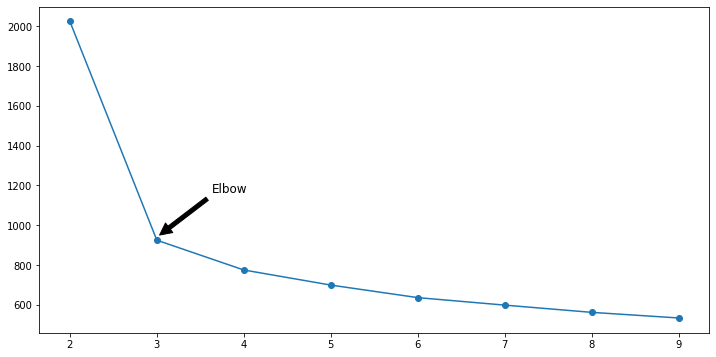

In [16]:
plt.figure(figsize=(12,6))
plt.plot( clusters_df.num_clusters, clusters_df.cluster_errors, marker = "o" )

plt.annotate('Elbow', xy=(3, 940), xytext=(55, 45),
             textcoords="offset points",
            arrowprops=dict(facecolor='black', shrink=0.05),
                fontsize=12, 
                color='black')

#### Observations
1. K-Means clustering suggest an elbow at 3
2. We will add the predictions from k-means clustering to kmeans_group column

In [17]:
clusters = KMeans(n_clusters=3, n_init = 5)
clusters.fit(cc_data_scaled)
prediction=clusters.predict(cc_data_scaled)
cc_data["kmeans_group"] = prediction 
cc_data_scaled["kmeans_group"] = prediction 

In [18]:
# Let's check the distribution in the groups
cc_data.kmeans_group.value_counts()

0    382
1    224
2     49
Name: kmeans_group, dtype: int64

In [19]:
for i in np.unique(cc_data.kmeans_group.values):
    print(f"Group value: {i}")
    for col in cc_data.columns[:-1]:
        print(f"Col: {col} Min: {cc_data.loc[cc_data.kmeans_group == i, col].min()} and max: {cc_data.loc[cc_data.kmeans_group == i, col].max()}")
        
    print("\n")

Group value: 0
Col: Avg_Credit_Limit Min: 5000 and max: 100000
Col: Total_Credit_Cards Min: 2 and max: 7
Col: Total_visits_bank Min: 1 and max: 5
Col: Total_visits_online Min: 0 and max: 3
Col: Total_calls_made Min: 0 and max: 4


Group value: 1
Col: Avg_Credit_Limit Min: 3000 and max: 50000
Col: Total_Credit_Cards Min: 1 and max: 4
Col: Total_visits_bank Min: 0 and max: 2
Col: Total_visits_online Min: 1 and max: 10
Col: Total_calls_made Min: 1 and max: 10


Group value: 2
Col: Avg_Credit_Limit Min: 84000 and max: 200000
Col: Total_Credit_Cards Min: 5 and max: 10
Col: Total_visits_bank Min: 0 and max: 1
Col: Total_visits_online Min: 6 and max: 15
Col: Total_calls_made Min: 0 and max: 3




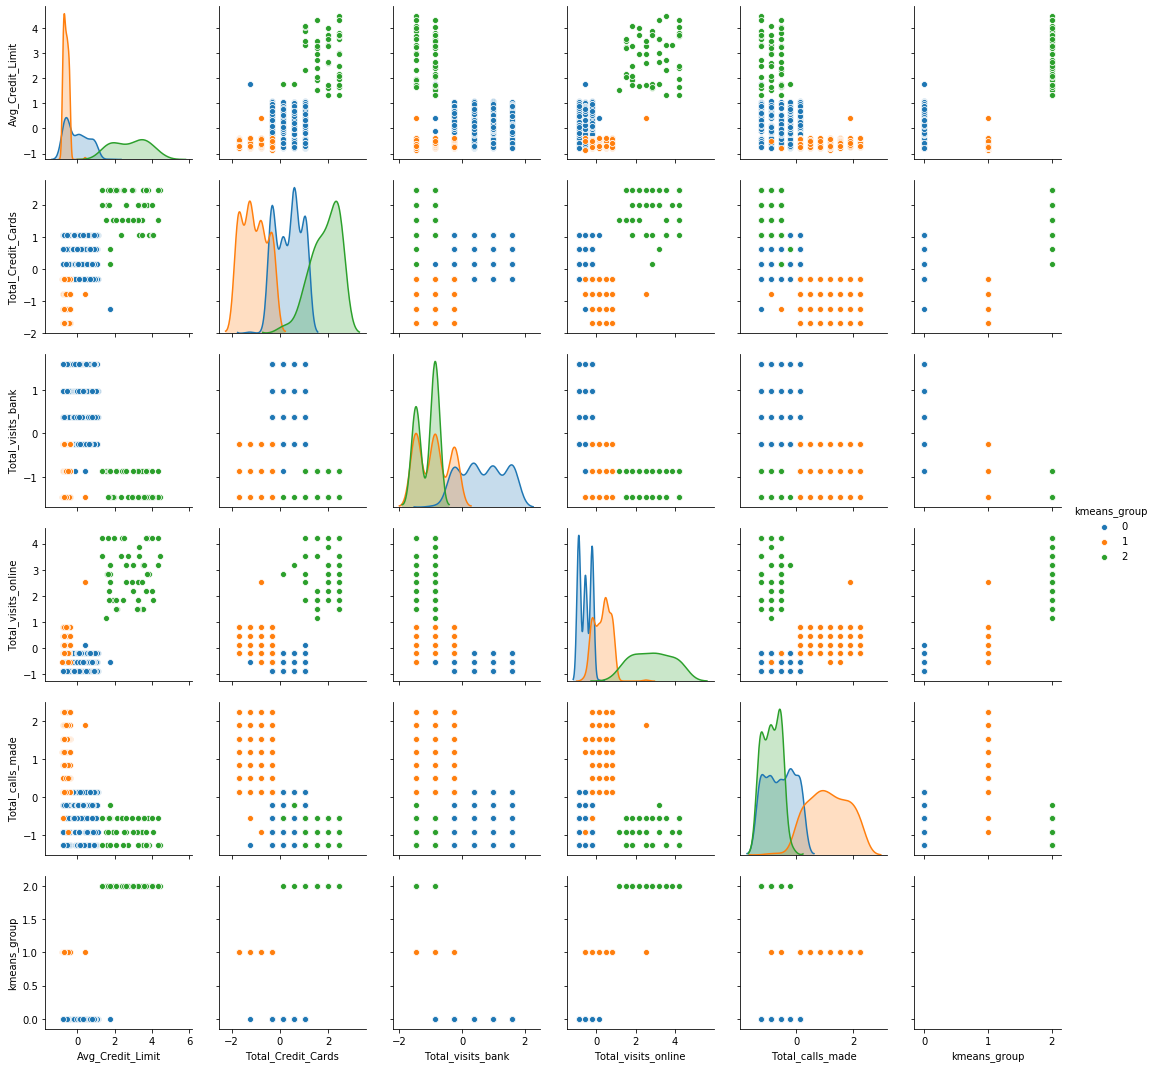

In [20]:
sns.pairplot(cc_data_scaled, hue='kmeans_group')

In [21]:
from sklearn.metrics import silhouette_score

cols = ['Avg_Credit_Limit', 'Total_Credit_Cards', 'Total_visits_bank',
       'Total_visits_online', 'Total_calls_made']

silhouette_score(cc_data_scaled[cols], cc_data_scaled.kmeans_group, random_state=11)

0.5154145560843687

#### Observations

Above analysis groups bank customers in 3 groups. One of the ways to think about 3 groups is as below:

<b>Characteristics of Group 0 OR medium credit limit group:</b>
1. Medium credit limits on credit cards
2. Low-Medium number of credit cards
3. Typically 3 visits per month to the bank
4. Minimal online activity
5. Very few calls made to the bank

<b>Characteristics of group 1 OR low credit limit group: </b>
1. Low credit limits
2. Low number of credit cards
3. Very few visits to bank
4. Medium online visits
5. Medium number of calls made

<b>Characterisitcs of group 2 OR high credit limit group:</b>
1. High credit limits
2. High number of credit cards
3. Very few to no visits to bank
4. Maxium online visits
5. Few calls


Silhoutter analysis suggests that our analysis is fairly reasonable

# Agglomerative Clustering

In [22]:
from sklearn.cluster import AgglomerativeClustering

model = AgglomerativeClustering(n_clusters=3, affinity='euclidean',  linkage='average')
model.fit(cc_data_scaled[cc_data_scaled.columns[:-1]])

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
                        connectivity=None, distance_threshold=None,
                        linkage='average', memory=None, n_clusters=3,
                        pooling_func='deprecated')

In [23]:
cc_data['Agglomerative_Groups'] = model.labels_
cc_data_scaled['Agglomerative_Groups'] = model.labels_

In [24]:
cc_data.Agglomerative_Groups.value_counts()

0    383
2    223
1     49
Name: Agglomerative_Groups, dtype: int64

In [25]:
for i in np.unique(cc_data.Agglomerative_Groups.values):
    print(f"Group value: {i}")
    for col in cc_data.columns[:-1]:
        print(f"Col: {col} Min: {cc_data.loc[cc_data.Agglomerative_Groups == i, col].min()} and max: {cc_data.loc[cc_data.Agglomerative_Groups == i, col].max()}")
        
    print("\n")

Group value: 0
Col: Avg_Credit_Limit Min: 5000 and max: 100000
Col: Total_Credit_Cards Min: 2 and max: 7
Col: Total_visits_bank Min: 1 and max: 5
Col: Total_visits_online Min: 0 and max: 3
Col: Total_calls_made Min: 0 and max: 4
Col: kmeans_group Min: 0 and max: 1


Group value: 1
Col: Avg_Credit_Limit Min: 84000 and max: 200000
Col: Total_Credit_Cards Min: 5 and max: 10
Col: Total_visits_bank Min: 0 and max: 1
Col: Total_visits_online Min: 6 and max: 15
Col: Total_calls_made Min: 0 and max: 3
Col: kmeans_group Min: 2 and max: 2


Group value: 2
Col: Avg_Credit_Limit Min: 3000 and max: 50000
Col: Total_Credit_Cards Min: 1 and max: 4
Col: Total_visits_bank Min: 0 and max: 2
Col: Total_visits_online Min: 1 and max: 10
Col: Total_calls_made Min: 1 and max: 10
Col: kmeans_group Min: 1 and max: 1




#### Observations

1. AgglomerativeClustering classifies the data exactly the same as k-means clustering except for 1 record
2. These results confirms our understanding from k-means clustering

# Cophenetic Coef and Dendograms

In [26]:
cols = ['Avg_Credit_Limit', 'Total_Credit_Cards', 'Total_visits_bank',
       'Total_visits_online', 'Total_calls_made']

metrics = ['euclidean', 'minkowski', 'jaccard', 'chebyshev', 'mahalanobis', 'cityblock']
methods = ['average', 'complete']

In [27]:
from scipy.cluster.hierarchy import cophenet, dendrogram, linkage
from scipy.spatial.distance import pdist

cophenetic_df = pd.DataFrame(columns=['metric', 'method', 'cophenetic_coef'])

for metric in metrics:
    for method in methods:
        Z = linkage(cc_data_scaled[cols], metric=metric, method=method)
        c, coph_dists = cophenet(Z , pdist(cc_data_scaled[cols]))
        dd = {
            'metric': metric, 
            'method': method, 
            'cophenetic_coef': c
        }
        cophenetic_df = cophenetic_df.append(dd, ignore_index=True)

        
for method in ['ward', 'centroid', 'median']:
    Z = linkage(cc_data_scaled[cols], metric='euclidean', method=method)
    c, coph_dists = cophenet(Z , pdist(cc_data_scaled[cols]))
    dd = {
        'metric': 'euclidean', 
        'method': method, 
        'cophenetic_coef': c
    }
    cophenetic_df = cophenetic_df.append(dd, ignore_index=True)
        
cophenetic_df

,metric,method,cophenetic_coef
0,euclidean,average,0.897868
1,euclidean,complete,0.867298
2,minkowski,average,0.897868
3,minkowski,complete,0.867298
4,jaccard,average,0.533589
5,jaccard,complete,0.188496
6,chebyshev,average,0.896046
7,chebyshev,complete,0.851859
8,mahalanobis,average,0.831883
9,mahalanobis,complete,0.656109


In [28]:
cophenetic_df[cophenetic_df.cophenetic_coef == cophenetic_df.cophenetic_coef.max()]

,metric,method,cophenetic_coef
0,euclidean,average,0.897868
2,minkowski,average,0.897868


In [29]:
Z = linkage(cc_data_scaled[cols], metric='euclidean', method='average')
c, coph_dists = cophenet(Z , pdist(cc_data_scaled[cols]))
c

0.8978684505898263

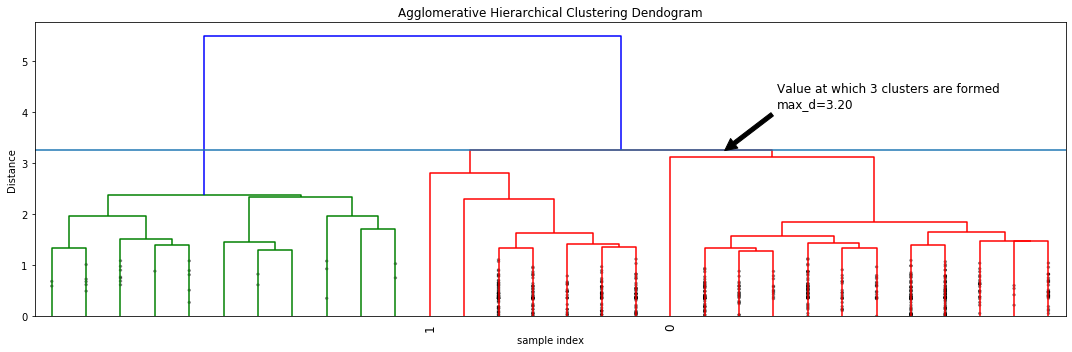

In [30]:
plt.figure(figsize=(15, 5))
plt.title('Agglomerative Hierarchical Clustering Dendogram')
plt.xlabel('sample index')
plt.ylabel('Distance')

dendrogram(
    Z,
    truncate_mode='lastp',
    p=30, # Zoom to level 30 otherwise it is not visible
    show_leaf_counts=False,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
)
plt.axhline(y=3.25)

plt.annotate('Value at which 3 clusters are formed\nmax_d=3.20', xy=(200, 3.20), xytext=(55, 45),
             textcoords="offset points",
            arrowprops=dict(facecolor='black', shrink=0.05),
                fontsize=12, 
                color='black')

plt.tight_layout()

In [31]:
from scipy.cluster.hierarchy import fcluster
max_d = 3.2
clusters = fcluster(Z, max_d, criterion='distance')
np.unique(clusters)

array([1, 2, 3], dtype=int32)

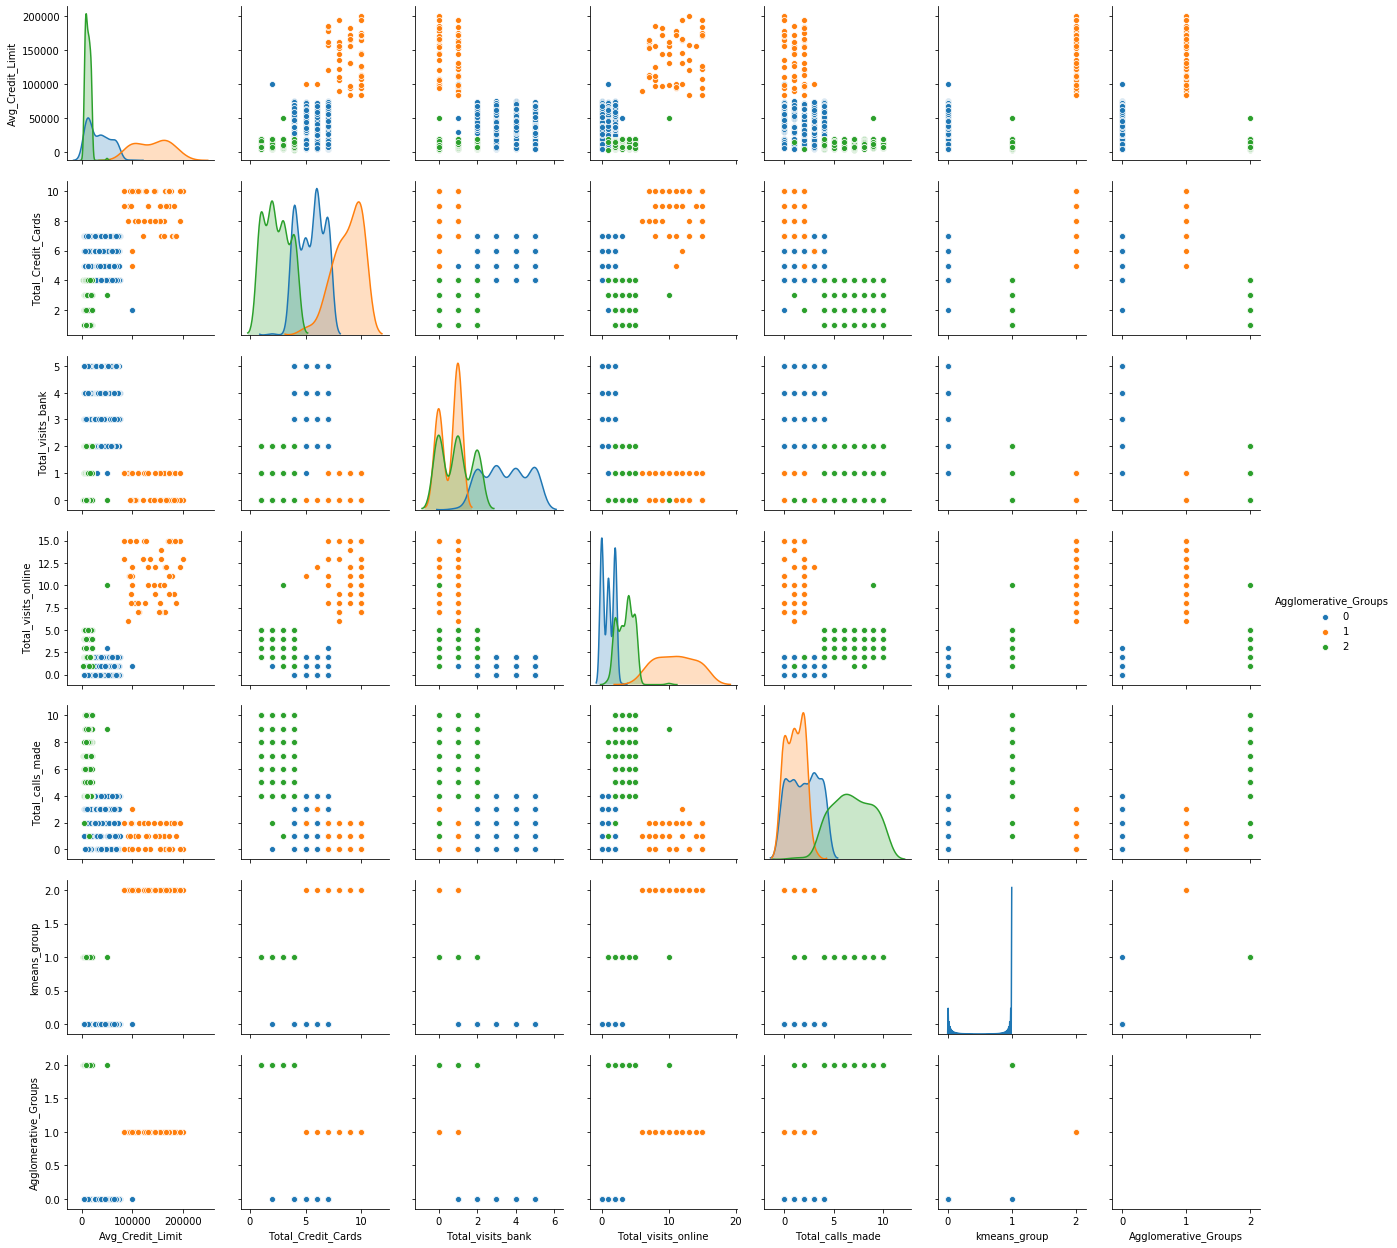

In [32]:
sns.pairplot(cc_data, hue='Agglomerative_Groups')

# Conclusion

1. Based on above analysis, the bank should categorize their customer based in 3 groups
2. These segments differ in all aspects (all features for provided datasets)
3. Both agglomerative and k-means clustering show same results

## Recommendations for marketting team
1. Focus on 3 different sections of the customer as described above
2. Three different campaigns can run for different sections of the customer as below <br />
2.1. Low credit limit group <br />
2.2. Medium credit limit group <br />
2.3. High credit limit group <br />


## Recommendations for Operations team
From the affected customers, it appears that the most calls are made by the low credit limit group. The operations team may check and group the queries from customers from this group and find a solution.

